In [1]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

import seaborn as sb
import scikitplot
from matplotlib import pyplot as plt

from sklearn.metrics import classification_report, accuracy_score


import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

from tensorflow.keras.callbacks import ModelCheckpoint
import cv2

# Training and pre-processing

loading the csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# data = pd.read_csv('fer2013.csv')
data = pd.read_csv('/content/drive/MyDrive/17644_MoodDetectives/Datasets/rafDB.csv')
images = data['pixels']
labels = data['emotion']

Preprocssing



In [5]:
def preprocess_images(images):
    images = np.array([np.fromstring(image, dtype=int, sep=' ').reshape(48, 48, 1) for image in images])
    images = np.expand_dims(images, axis=-1)
    images = images / 255.0
    return images

images = preprocess_images(images)


Split the Dataset

In [6]:
X_train, X_val, y_train, y_val = train_test_split(images, 
                                                  labels, 
                                                  test_size=0.2,
                                                  shuffle = True, 
                                                  stratify = labels,
                                                  random_state=42
                                                  )


Define the CNN Model

In [7]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])


Compile and Train the Model

In [8]:
epochs = 24
batch_size = 32 # default size
steps_per_epoch = len(X_train)/batch_size

checkpoint_path = "/content/drive/MyDrive/17644_MoodDetectives/9_Layer_CNN_Model/Seven_Emotions/RAFDb/Checkpoints/"
model_checkpoints = ModelCheckpoint(
    filepath = checkpoint_path + "my_cnn_model_epoch{epoch}.h5",
    save_weigts_only = False,
    save_freq = int(4 * steps_per_epoch)
    
)

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    callbacks =  model_checkpoints,
    epochs=24
    )

Epoch 1/24
384/384 [==============================] - 14s 11ms/step - loss: 1.5461 - accuracy: 0.4284 - val_loss: 1.2818 - val_accuracy: 0.5235
Epoch 2/24
384/384 [==============================] - 4s 10ms/step - loss: 1.1171 - accuracy: 0.6002 - val_loss: 1.0972 - val_accuracy: 0.5997
Epoch 3/24
384/384 [==============================] - 2s 6ms/step - loss: 0.9306 - accuracy: 0.6682 - val_loss: 0.8795 - val_accuracy: 0.6926
Epoch 4/24
384/384 [==============================] - 3s 8ms/step - loss: 0.8133 - accuracy: 0.7116 - val_loss: 0.8202 - val_accuracy: 0.7099
Epoch 5/24
384/384 [==============================] - 2s 5ms/step - loss: 0.7424 - accuracy: 0.7383 - val_loss: 0.7931 - val_accuracy: 0.7177
Epoch 6/24
384/384 [==============================] - 2s 6ms/step - loss: 0.6670 - accuracy: 0.7658 - val_loss: 0.7763 - val_accuracy: 0.7269
Epoch 7/24
384/384 [==============================] - 3s 7ms/step - loss: 0.6054 - accuracy: 0.7884 - val_loss: 0.7604 - val_accuracy: 0.7422
Epo

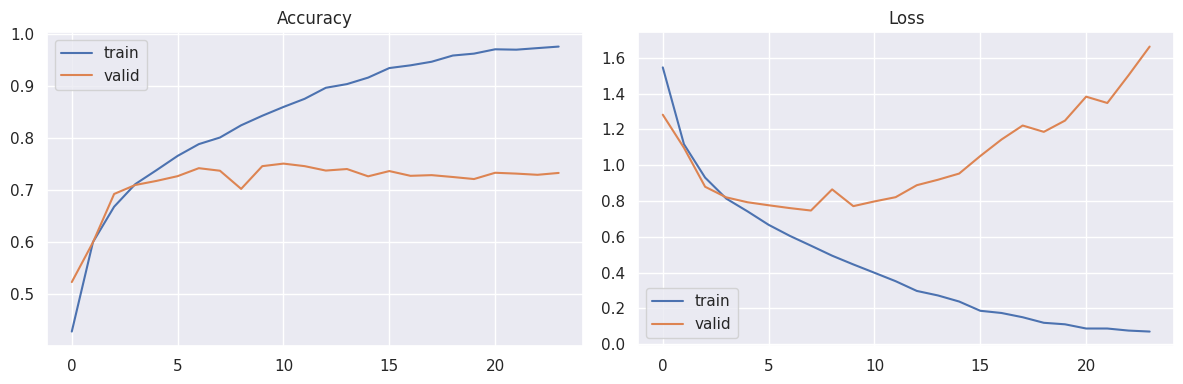

In [10]:
# metrics

sb.set()
figure = plt.figure(0, (12,4))

# Plot Accuracy
ax = plt.subplot(1,2,1)
sb.lineplot(
    x = history.epoch,
    y = history.history["accuracy"], 
    label="train"
)

sb.lineplot(
    x = history.epoch,
    y = history.history["val_accuracy"], 
    label="valid"
)

plt.title("Accuracy")
plt.tight_layout()

# Plot Loss
ax = plt.subplot(1,2,2)
sb.lineplot(
    x = history.epoch,
    y = history.history["loss"], 
    label="train"
)

sb.lineplot(
    x = history.epoch,
    y = history.history["val_loss"], 
    label="valid"
)

plt.title("Loss")
plt.tight_layout()

In [11]:
# acccuracy

prediction = model.predict(X_val)

accuracy_score( y_val , np.argmax(prediction, axis=1) )

96/96 [==============================] - 0s 2ms/step


0.7330508474576272

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

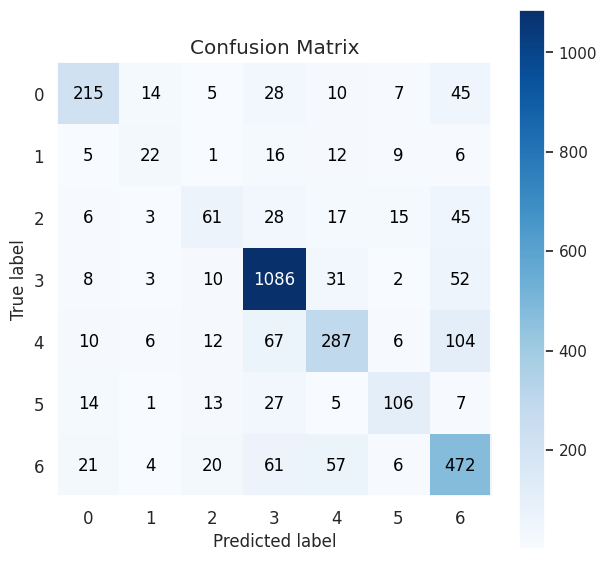

In [12]:
# Confusion Matrix

class_predictions = np.argmax(prediction, axis=1)

scikitplot.metrics.plot_confusion_matrix(
    y_val,
    class_predictions,
    figsize=(7,7)
)

In [13]:
print(
    "Total Wrong Predictions:", 
      np.sum(
          y_val!= class_predictions
      )
    )

print(
    classification_report(
      y_val, class_predictions
    )
  )

Total Wrong Predictions: 819
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       324
           1       0.42      0.31      0.35        71
           2       0.50      0.35      0.41       175
           3       0.83      0.91      0.87      1192
           4       0.68      0.58      0.63       492
           5       0.70      0.61      0.65       173
           6       0.65      0.74      0.69       641

    accuracy                           0.73      3068
   macro avg       0.65      0.60      0.62      3068
weighted avg       0.73      0.73      0.73      3068



1/1 [==============================] - 0s 38ms/step


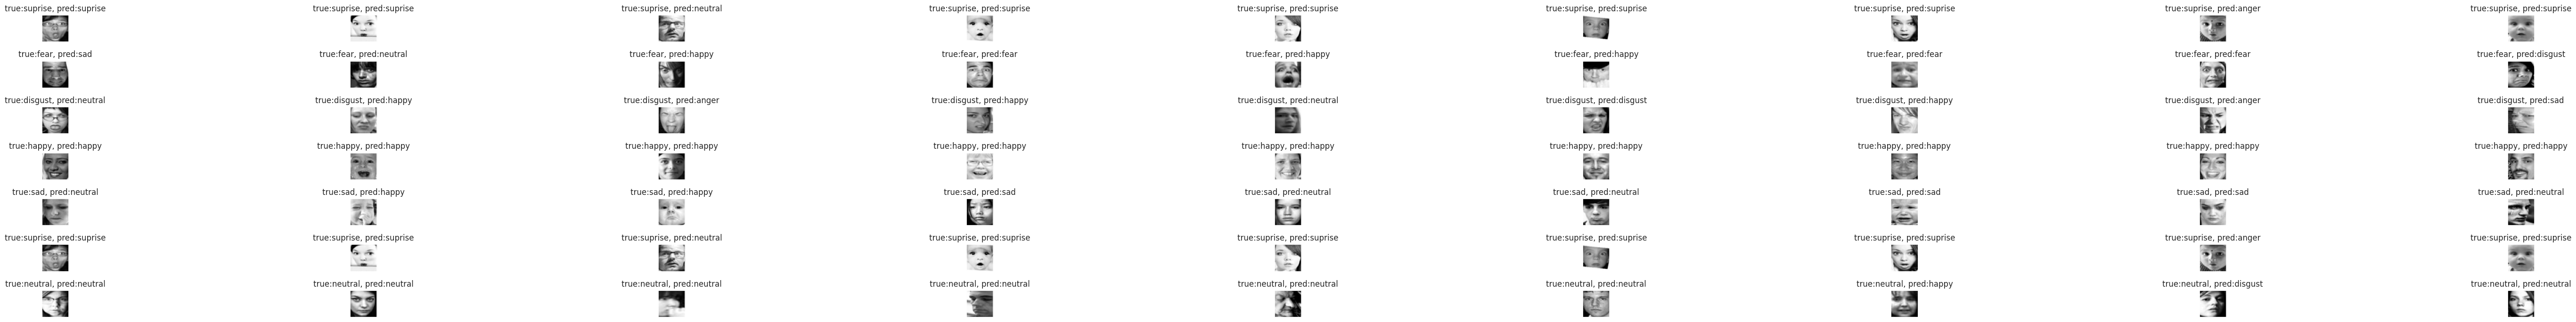

In [14]:
# check some images model got wrong
figure = plt.figure(1, (63,7))

map_emotions ={
    0: "suprise",
    1: "fear",
    2: "disgust",
    3: "happy",
    4: "sad",
    5: "anger",
    6: "neutral"
}

np.random.seed(2)

random_suprise_images = np.random.choice(
    np.where(y_val == 0)[0],
    size=9
)

random_fear_images = np.random.choice(
    np.where(y_val == 1)[0],
    size=9
)
  

random_disgust_images = np.random.choice(
    np.where(y_val==2)[0],
    size=9
    )

random_happy_images = np.random.choice(
    np.where(y_val == 3)[0],
    size=9
)

random_sad_images = np.random.choice(
    np.where(y_val == 4)[0],
    size=9
)
  

random_anger_images = np.random.choice(
    np.where(y_val==5)[0],
    size=9
    )

random_neutral_images = np.random.choice(
    np.where(y_val==6)[0],
    size=9
    )

for i, (suprise_index, 
        fear_index, 
        disgust_index,
        happy_index,
        sad_index,
        anger_index,
        neutral_index) in enumerate(zip(random_suprise_images, 
                                        random_fear_images, 
                                        random_disgust_images,
                                        random_happy_images,
                                        random_sad_images,
                                        random_anger_images,
                                        random_neutral_images)):
  ax = plt.subplot(7,9, i+1)
  sample_image = X_val[suprise_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])
  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:suprise, pred:{map_emotions[sample_class_prediction]}")
  

  ax = plt.subplot(7,9, i+10)
  sample_image = X_val[fear_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:fear, pred:{map_emotions[sample_class_prediction]}")

  ax = plt.subplot(7,9, i+19)
  sample_image = X_val[disgust_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:disgust, pred:{map_emotions[sample_class_prediction]}")

  ax = plt.subplot(7,9, i+28)
  sample_image = X_val[happy_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:happy, pred:{map_emotions[sample_class_prediction]}")

  ax = plt.subplot(7,9, i+37)
  sample_image = X_val[sad_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:sad, pred:{map_emotions[sample_class_prediction]}")

  ax = plt.subplot(7,9, i+46)
  sample_image = X_val[suprise_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:suprise, pred:{map_emotions[sample_class_prediction]}")

  ax = plt.subplot(7,9, i+55)
  sample_image = X_val[neutral_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:neutral, pred:{map_emotions[sample_class_prediction]}")

plt.tight_layout()

Capture photo

In [15]:
# Save the Model

model.save(
    "/content/drive/MyDrive/17644_MoodDetectives/9_Layer_CNN_Model/Seven_Emotions/RAFDb/cnn_raf_model_stopped.h5"
    )


load the Haar cascade

In [16]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


Define the emotions

In [17]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Predit funcition

In [18]:
def predict_emotion(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48))
        face = np.expand_dims(face, axis=-1)
        face = np.expand_dims(face, axis=0)
        prediction = model.predict(face)
        emotion = emotions[np.argmax(prediction)]
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    return frame


In [19]:
cap = cv2.VideoCapture(0)

Test on live video

In [20]:
while True:
    ret, frame = cap.read()
    if ret:
        frame = predict_emotion(frame)
        cv2.imshow('Live Facial Emotion Detection', frame)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: ignored